<a href="https://colab.research.google.com/github/GustavBoye/DRED_Autoencoder/blob/main/MoreData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saved trends to trends.npy with shape (2050, 296)


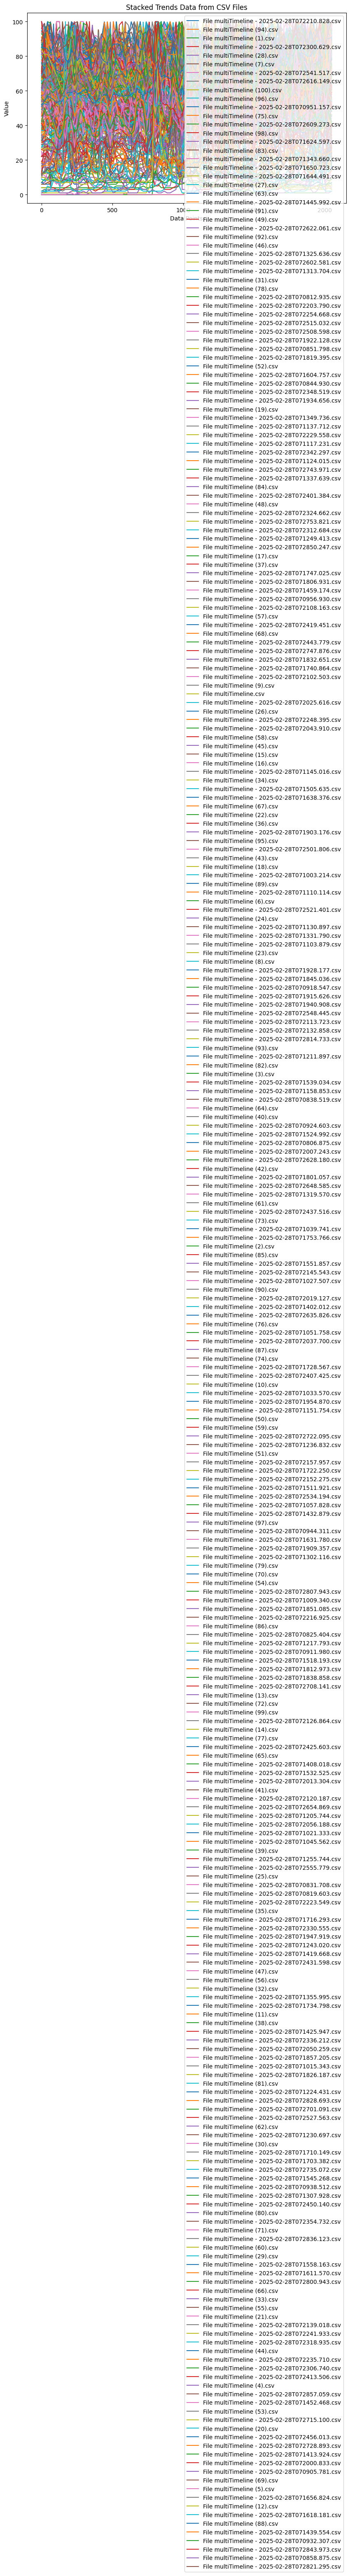

In [7]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

def load_csv_trend_from_folder_with_skip(folder_path, target_size=2050):
    all_data = []

    # List all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    for file_name in csv_files:
        file_path = os.path.join(folder_path, file_name)

        # Load data from each CSV file
        file_data = []
        with open(file_path, newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)

            # Skip the first 3 rows
            for _ in range(3):
                next(reader, None)

            # Read the remaining rows
            for row in reader:
                try:
                    # Convert the second column to float
                    file_data.append(float(row[1]))
                except (ValueError, IndexError):
                    file_data.append(0.0)  # Replace invalid values with 0.0

        all_data.append(file_data)

    # Convert to numpy array
    all_data = np.array(all_data, dtype=float)

    # Interpolate all data to match target_size
    interpolated_trends = []
    for row in all_data:
        interpolated_row = np.interp(np.linspace(0, len(row) - 1, target_size), np.arange(len(row)), row)
        interpolated_trends.append(interpolated_row)

    interpolated_trends = np.array(interpolated_trends).T  # Transpose to shape (2050, X)

    return interpolated_trends, csv_files

def save_trends_to_npy(folder_path, output_file="trends.npy"):
    # Load and process CSV files
    all_trends, csv_files = load_csv_trend_from_folder_with_skip(folder_path, target_size=2050)

    # Save to .npy file
    np.save(output_file, all_trends)
    print(f"Saved trends to {output_file} with shape {all_trends.shape}")

    # Plot the trends
    plt.figure(figsize=(10, 6))
    for idx, file_data in enumerate(all_trends.T):  # Iterate over columns (trends)
        plt.plot(file_data, label=f'File {csv_files[idx]}')

    plt.title('Stacked Trends Data from CSV Files')
    plt.xlabel('Data Points')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Run the script
folder_path = "Trends"  # Change this to your folder path
save_trends_to_npy(folder_path, "trends.npy")


In [3]:
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


# Helper function for normalization
def normalize_min_max(data):
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

# Define input tickers
input_tickers = [
    'IAG', 'DRD', 'GOLD', 'NEM', 'GLD', 'AEM', 'PAAS', 'AU', 'KGC', 'WPM', 'AG', 'NG', 'HMY', 'GMAB', 'NMM', 'CSIQ', 'MAG', 'CSCO', 'FSM', 'OR', 'PYPL', 'HGBL', 'EW', 'BVN', 'RGLD',
    'SEDG', 'FSLR', 'ENPH', 'JKS', 'RUN', 'NEE', 'CWEN', 'LNTH', 'CHKP', 'PANW',
    'MSFT', 'NVDA', 'AMD', 'INTC', 'GOOG', 'META', 'TSM', 'INTU', 'UMC', 'MU', 'ORCL', 'ASML', 'DELL', 'TXN', 'QRVO', 'BIDU', 'SMCI',
    'TSLA', 'ALB', 'LTBR', 'CAT', 'BWXT', 'BA', 'SIEGY', 'SQM', 'MA', 'MCD', 'AVXL', 'SRTS',
    'HDSN', 'CCJ', 'AMZN', 'WELL', 'MPLX', 'TSE', 'ELD', 'UTHR', 'ABT', 'JNJ', 'BABA', 'JPM', 'SB', 'TER', 'ARKQ', 'BLX', 'NRG', 'LIT', 'FLXS', 'BAESY', 'STE', 'IBM', 'KO', 'PEP', 'GS', 'V'
]

import time
import pandas as pd # Import pandas here
import yfinance as yf

def batch_download(tickers, start, end, batch_size=5, datatype='Close'):
    all_data = {}
    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i + batch_size]
        print(f"Downloading data for: {batch_tickers}")

        # Try to download the data for this batch
        try:
            data = yf.download(batch_tickers, start=start, end=end, interval="1d")[datatype]
            all_data.update(data.to_dict())
        except Exception as e:
            print(f"Error downloading data for {batch_tickers}: {e}")
            time.sleep(0.1)  # Wait for a bit before retrying if an error occurs

        time.sleep(0.2)  # Sleep between batches to avoid hitting rate limits
    return pd.DataFrame(all_data)

TODAY = "2025-02-28"

# Fetch stock data in batches
data = batch_download(input_tickers, start="2017-01-01", end=TODAY, datatype='Close')
data_volume = batch_download(input_tickers, start="2017-01-01", end=TODAY, datatype='Volume')
data_high = batch_download(input_tickers, start="2017-01-01", end=TODAY, datatype='High')
data_low = batch_download(input_tickers, start="2017-01-01", end=TODAY, datatype='Low')

# Preprocess the data
scaler = MinMaxScaler()
scaler_vol = MinMaxScaler()
scaler_high = MinMaxScaler()
scaler_low = MinMaxScaler()

data_scaled = scaler.fit_transform(data)
data_scaled_vol = scaler_vol.fit_transform(data_volume)
data_scaled_high = scaler_high.fit_transform(data_high)
data_scaled_low = scaler_low.fit_transform(data_low)

np.save("data_scaled.npy", data_scaled)
np.save("data_scaled_vol.npy", data_scaled_vol)
np.save("data_scaled_high.npy", data_scaled_high)
np.save("data_scaled_low.npy", data_scaled_low)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


In [ ]:


data_scaled = np.load("data_scaled.npy")
data_scaled_vol = np.load("data_scaled_vol.npy")
data_scaled_high = np.load("data_scaled_high.npy")
data_scaled_low = np.load("data_scaled_low.npy")
data_trends = np.load("trends.npy")

# Check for NaNs or infinite values
if np.isnan(data_trends).any():
    print("Data contains NaNs")
elif np.isinf(data_trends).any():
    print("Data contains infinite values")
else:
    print("Data is clean")

# Helper function for normalization
def normalize_trends(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Add a small epsilon to avoid division by zero
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # Replace zero ranges with 1 to prevent NaNs

    d = (data - min_vals) / range_vals
    return d




DAYS = 16
HISTORY = 16


# Function to create supervised learning dataset

def create_input(data, vol, high, low, trends, time_steps=0):
    X=[]
    data_to_insert_a = normalize_min_max(data[-time_steps:])
    data_to_insert_b = normalize_min_max(vol[-time_steps:])
    data_to_insert_c = normalize_min_max(high[-time_steps:])
    data_to_insert_d = normalize_min_max(low[-time_steps:])
    data_trends = normalize_trends(trends[-time_steps:])
    data_to_insert = np.concatenate([data_to_insert_a, data_to_insert_b,data_to_insert_c,data_to_insert_d, data_trends], axis=1)
    X.append(data_to_insert)


    # Convert to a numpy array and return
    return np.array(X)



def create_dataset(data, vol, high, low, trends, time_steps=0, future_steps=0, threshold=0.1, inverted=False):
    if inverted:
      data = 1-data
      high = 1-high
      low = 1-low

    X, y = [], []
    for i in range(len(data) - time_steps - future_steps):
        # Normalize and prepare input data
        data_to_insert_a = normalize_min_max(data[i:i + time_steps])
        data_to_insert_b = normalize_min_max(vol[i:i + time_steps])
        data_to_insert_c = normalize_min_max(high[-time_steps:])
        data_to_insert_d = normalize_min_max(low[-time_steps:])
        data_trends = normalize_trends(trends[-time_steps:])
        data_to_insert = np.concatenate([data_to_insert_a, data_to_insert_b,data_to_insert_c,data_to_insert_d, data_trends], axis=1)
        X.append(data_to_insert)

        future_prices = data[i + time_steps:i + time_steps + future_steps]
        current_price = data[i + time_steps - 1]
        future_average_price = np.mean(future_prices, axis=0)
        target = future_average_price - current_price
        y.append(target)

    return np.array(X), np.array(y)


# Prepare dataset (200-day version)
X_s, y_s = create_dataset(data_scaled, data_scaled_vol, data_scaled_high, data_scaled_low, data_trends, time_steps=HISTORY, future_steps=DAYS)
X_inv_s, y_inv_s = create_dataset(data_scaled, data_scaled_vol, data_scaled_high, data_scaled_low, data_trends, time_steps=HISTORY, future_steps=DAYS, inverted=True)
X_combined_s = np.concatenate((X_s, X_inv_s), axis=0)
y_combined_s = np.concatenate((y_s, y_inv_s), axis=0)
input_data = create_input(data_scaled, data_scaled_vol, data_scaled_high, data_scaled_low, data_trends, time_steps=HISTORY)


def build_model(shape1, shape2, version):
    input_layer = tf.keras.layers.Input(shape=(shape1, shape2))

    if version == 0:
      x = tf.keras.layers.SpatialDropout1D(0.8)(input_layer)
      x = tf.keras.layers.Conv1D(64, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)
      x = tf.keras.layers.Dropout(0.4)(x)

      x = tf.keras.layers.Conv1D(64, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # ✅ Add Transformer attention
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)
      x = tf.keras.layers.Flatten()(x)

      dense1 = tf.keras.layers.Dense(512, activation='gelu')(x)
      dense1 = tf.keras.layers.Dropout(0.2)(dense1)
      dense2 = tf.keras.layers.Dense(512, activation='gelu')(dense1)
      dense = dense1+dense2

      output = tf.keras.layers.Dense(len(input_tickers))(dense)
    elif version == 1:
      x = tf.keras.layers.SpatialDropout1D(0.6)(input_layer)
      x = tf.keras.layers.GaussianNoise(0.2)(x)
      x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)
      x = tf.keras.layers.Dropout(0.2)(x)

      x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # ✅ Add Transformer attention
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)
      x = tf.keras.layers.Flatten()(x)

      dense1 = tf.keras.layers.Dense(256, activation='gelu')(x)
      dense1 = tf.keras.layers.Dropout(0.4)(dense1)
      dense2 = tf.keras.layers.Dense(256, activation='gelu')(dense1)
      dense = dense1+dense2

      output = tf.keras.layers.Dense(len(input_tickers))(dense)
    elif version == 2:
      x = tf.keras.layers.SpatialDropout1D(0.4)(input_layer)
      x = tf.keras.layers.GaussianNoise(0.1)(x)
      x = tf.keras.layers.Conv1D(64, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(128, 5, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=32)(x, x)  # ✅ Add Transformer attention
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=32)(x, x)  # ✅ Add Transformer attention
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Flatten()(x)

      dense1 = tf.keras.layers.Dense(256, activation='gelu')(x)
      dense1 = tf.keras.layers.Dropout(0.4)(dense1)
      dense2 = tf.keras.layers.Dense(256, activation='gelu')(dense1)
      dense = dense1+dense2

      output = tf.keras.layers.Dense(len(input_tickers))(dense)

    elif version == 3:
      x = tf.keras.layers.SpatialDropout1D(0.3)(input_layer)
      x = tf.keras.layers.GaussianNoise(0.13)(x)
      x = tf.keras.layers.Conv1D(64, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(256, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Flatten()(x)

      dense1 = tf.keras.layers.Dense(256, activation='gelu')(x)
      dense2 = tf.keras.layers.Dense(256, activation='gelu')(dense1)
      dense = dense1+dense2

      dense1 = tf.keras.layers.Dense(256, activation='gelu')(dense)
      dense2 = tf.keras.layers.Dense(256, activation='gelu')(dense1)
      F = dense1+dense2

      output = tf.keras.layers.Dense(len(input_tickers))(F)

    elif version == 4:
      x = tf.keras.layers.SpatialDropout1D(0.3)(input_layer)
      x = tf.keras.layers.GaussianNoise(0.02)(x)
      x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.006))(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(256, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Conv1D(256, 3, strides=2, padding="same")(x)
      x = tf.keras.layers.LayerNormalization()(x)
      x = tf.keras.layers.Activation('gelu')(x)

      x = tf.keras.layers.Flatten()(x)

      dense1 = tf.keras.layers.Dense(256, activation='gelu')(x)
      dense2 = tf.keras.layers.Dense(256, activation='gelu')(dense1)
      dense = dense1+dense2

      dense1 = tf.keras.layers.Dense(256, activation='gelu')(dense)
      dense2 = tf.keras.layers.Dense(256, activation='gelu')(dense1)
      F = dense1+dense2

      output = tf.keras.layers.Dense(len(input_tickers))(F)


    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model


# Training setup
num_models = 4
early_stopping = EarlyStopping(monitor='val_loss', patience=32, min_delta=1e-4, restore_best_weights=True, mode='min', verbose=1)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=16, verbose=1)

import random
# Train the ensemble (200-day version)
ensemble = []
for i in range(num_models):
    print(f"Training model {i+1}/{num_models} for {DAYS}-day prediction...")
    model = build_model(X_combined_s.shape[1], X_combined_s.shape[2], i)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_combined_s, y_combined_s, epochs=20, batch_size=32, validation_split=0.3, verbose=1, callbacks=[early_stopping, lr_scheduler])
    ensemble.append(model)

# Predictions (200-day version)
predictions = {ticker: [] for ticker in input_tickers}
for idx, ticker in enumerate(input_tickers):
    predictions[ticker] = np.mean([m(input_data).numpy()[:, idx] for m in ensemble], axis=0)

# Plot predictions
fig, ax = plt.subplots(figsize=(18, 10))
tickers_range = np.arange(len(input_tickers))
pred_days = np.array([predictions[ticker] for ticker in input_tickers]).flatten()
ax.bar(tickers_range, pred_days, color='blue', width=0.6, label='200-Day Prediction')

ax.set_title("200-Day Predictions for All Tickers", fontsize=16)
ax.set_xlabel("Tickers", fontsize=14)
ax.set_ylabel("Predicted Change", fontsize=14)
ax.set_xticks(tickers_range)
ax.set_xticklabels(input_tickers, rotation=45, fontsize=10)
ax.legend(title="Prediction Length", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

import pandas as pd

# Convert predictions dictionary to DataFrame
predictions_df = pd.DataFrame.from_dict(predictions, orient='index', columns=['{DAYS}-Day Prediction'])

# Save as CSV
predictions_df.to_csv(f"predictions_{DAYS}.csv")

# Download in Colab
from google.colab import files
files.download(f"predictions_{DAYS}.csv")

Data is clean
Training model 1/4 for 16-day prediction...
Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0917 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0195 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0064 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0029 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0018 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0015 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0014 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0013 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0013 - v

In [ ]:
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


# Helper function for normalization
def normalize_min_max(data):
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

# Define input tickers
input_tickers = [
    'IAG', 'DRD', 'GOLD', 'NEM', 'GLD', 'AEM', 'PAAS', 'AU', 'KGC', 'WPM', 'AG', 'NG', 'HMY', 'GMAB', 'NMM', 'CSIQ', 'MAG', 'CSCO', 'FSM', 'OR', 'PYPL', 'HGBL', 'EW', 'BVN', 'RGLD',
    'SEDG', 'FSLR', 'ENPH', 'JKS', 'RUN', 'NEE', 'CWEN', 'LNTH', 'CHKP', 'PANW',
    'MSFT', 'NVDA', 'AMD', 'INTC', 'GOOG', 'META', 'TSM', 'INTU', 'UMC', 'MU', 'ORCL', 'ASML', 'DELL', 'TXN', 'QRVO', 'BIDU', 'SMCI',
    'TSLA', 'ALB', 'LTBR', 'CAT', 'BWXT', 'BA', 'SIEGY', 'SQM', 'MA', 'MCD', 'AVXL', 'SRTS',
    'HDSN', 'CCJ', 'AMZN', 'WELL', 'MPLX', 'TSE', 'ELD', 'UTHR', 'ABT', 'JNJ', 'BABA', 'JPM', 'SB', 'TER', 'ARKQ', 'BLX', 'NRG', 'LIT', 'FLXS', 'BAESY', 'STE', 'IBM', 'KO', 'PEP', 'GS', 'V'
]

import time
import pandas as pd # Import pandas here
import yfinance as yf

def batch_download(tickers, start, end, batch_size=5, datatype='Close'):
    all_data = {}
    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i + batch_size]
        print(f"Downloading data for: {batch_tickers}")

        # Try to download the data for this batch
        try:
            data = yf.download(batch_tickers, start=start, end=end, interval="1d")[datatype]
            all_data.update(data.to_dict())
        except Exception as e:
            print(f"Error downloading data for {batch_tickers}: {e}")
            time.sleep(0.2)  # Wait for a bit before retrying if an error occurs

        time.sleep(0.5)  # Sleep between batches to avoid hitting rate limits
    return pd.DataFrame(all_data)

# Fetch stock data in batches
data = batch_download(input_tickers, start="2017-01-01", end="2025-02-27", datatype='Close')
data_volume = batch_download(input_tickers, start="2017-01-01", end="2025-02-27", datatype='Volume')
data_high = batch_download(input_tickers, start="2017-01-01", end="2025-02-27", datatype='High')
data_low = batch_download(input_tickers, start="2017-01-01", end="2025-02-27", datatype='Low')

# Preprocess the data
scaler = MinMaxScaler()
scaler_vol = MinMaxScaler()
scaler_high = MinMaxScaler()
scaler_low = MinMaxScaler()

data_scaled = scaler.fit_transform(data)
data_scaled_vol = scaler_vol.fit_transform(data_volume)
data_scaled_high = scaler_high.fit_transform(data_high)
data_scaled_low = scaler_low.fit_transform(data_low)

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  2 of 2 completed


[*******************   40%                       ]  2 of 5 completed

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed


[**********************80%*************          ]  4 of 5 completed

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed


[**********************80%*************          ]  4 of 5 completed

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed